In this notebook we'll solve the Bernoulli Bandits problem using the QCLP formulation presented in the paper below:
https://www.ijcai.org/Proceedings/07/Papers/389.pdf

I'll also be borrowing from this video and the code presented in it:
https://www.youtube.com/watch?v=8GuQAfyvWYc&list=PLRwcSE2bmyBxc9u_tV65sZTGy729nqgiv&index=16&ab_channel=ICTPQuantitativeLifeSciences

In [1]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import sys
# append a new directory to sys.path
sys.path.append("c:\\Users\\Tassili\\Desktop\\FSC-optimization-main")
from QCLP_formulation import *
import networkx as nx
import os
os.environ['NEOS_EMAIL'] = 'malikbf5@gmail.com' 

# Two-armed Bernoulli Bandits...

  Credits: Andrea Mazzolini, Alberto Pezzotta 

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="200">
</div>

In the most general case, there is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="200">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll choose to focus on two symmetric states (A,B) of this square where we have the following probabilities:  
  Probability of winning in state A having chosen action (arm) 1: $P(r = 1 \,|\, s= A, a=1) = \theta$   
  Probability of winning in state A having chosen action (arm) 2: $P(r = 1 \,|\, s= A, a=2) = 1 - \theta$   
  Probability of winning in state B having chosen action (arm) 1: $P(r = 1 \,|\, s= B, a=1) = 1 - \theta$   
  Probability of winning in state B having chosen action (arm) 2: $P(r = 1 \,|\, s= B, a=2) = \theta$   

Upon choosing $\theta$ we get the two states:

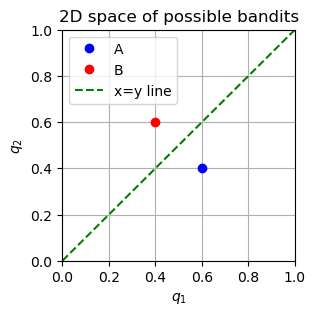

In [2]:
thetatest = 0.6
# Define the coordinates of the two points
point1 = (thetatest, 1- thetatest)
point2 = (1- thetatest, thetatest)

# Extract x and y coordinates of each point
x1, y1 = point1
x2, y2 = point2

# Plot the points
plt.plot(x1, y1, 'bo', label='A')
plt.plot(x2, y2, 'ro', label='B')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

# set plot size
plt.gcf().set_size_inches(3, 3)
# Show plot
plt.show()


Following this we define our POMDP parameter values

In [3]:
#Define POMDP parameters

num_states = 2 # Number of states
num_actions = 2 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # state A & B
a = list(range(num_actions)) # pull arm 1 or pull arm 2
o = list(range(num_observations))  # recieve reward 1 or 0

b0 = np.ones((num_states)) / num_states # uniform initial distribution over states
gamma = 0.5 # Discount factor 
theta = 0.8 # Bernoulli parameter for the reward

# P(s'|s,a) in this case equals 1 when s' = s and 0 otherwise
state_transition_model = np.zeros((num_states, num_actions, num_states)) 
for state, sprime, action in product(s,s,a):
    if state ==  sprime:
        state_transition_model[sprime, action, state] = 1

# R(s,a), since the reward is stochastic we take instead the average reward for each arm and state
reward_model = np.zeros((num_states, num_actions))
# state A
reward_model[0, 0], reward_model[0, 1] = theta, 1 - theta
# state B
reward_model[1, 0], reward_model[1, 1] = 1 - theta, theta

def bernoulliprob(p,y):
    return p**y * (1-p)**(1-y)

# O(o|s',a) the probability of observing reward o in state s' after taking action a
observation_model = np.zeros((num_states, num_actions, num_observations)) 
for state, action, observation in product(s,a,o):
    if state == action:
        observation_model[state,action,observation] = bernoulliprob(theta, observation)
    else:
        observation_model[state,action,observation] = bernoulliprob(1-theta, observation)


Visualizing POMDP parameter values

In [4]:
def statename(state):
    return 'A' if state == 0 else 'B'
state_transition_model_dict = {
    str((statename(sprime),action +1,statename(state))): state_transition_model[sprime,action,state]
    for sprime,action,state in product(s,a,s)
}
state_transition_model_df = pd.DataFrame(state_transition_model_dict, index=['Transition probability']) 
state_transition_model_df = state_transition_model_df.rename_axis("(s',a,s)", axis="columns")
state_transition_model_df

"(s',a,s)","('A', 1, 'A')","('A', 1, 'B')","('A', 2, 'A')","('A', 2, 'B')","('B', 1, 'A')","('B', 1, 'B')","('B', 2, 'A')","('B', 2, 'B')"
Transition probability,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [5]:
rewarddf = pd.DataFrame(reward_model, index=['A', 'B'], columns=['Arm 1', 'Arm 2'])
rewarddf.rename_axis("state", axis="index")

,Arm 1,Arm 2
state,,
A,0.8,0.2
B,0.2,0.8


In [6]:
observation_model_dict = {
    (str((statename(sprime),action +1,observation))): observation_model[sprime,action,observation]
    for sprime,action,observation in product(s,a,o) }
observation_model_df = pd.DataFrame(observation_model_dict, index=['Observation probability'])
observation_model_df.rename_axis("(s',a,o)", axis="index")

,"('A', 1, 0)","('A', 1, 1)","('A', 2, 0)","('A', 2, 1)","('B', 1, 0)","('B', 1, 1)","('B', 2, 0)","('B', 2, 1)"
"(s',a,o)",,,,,,,,
Observation probability,0.2,0.8,0.8,0.2,0.8,0.2,0.2,0.8


# QCLP formulation
<div>
<img src="QCLP formulation.PNG" width="600">
</div>

Where:  
The variable $x(q', a, q, o)$ represents $P(q', a|q, o)$  
The variable $y(q, s)$ represents $V(q, s)$  
$q_0$ is the initial controller node  
$o_k$ is an arbitrary fixed observation  

Note that $P(q', a|q, o)= P(q'|q, o) P(a|q)$ 

And $\sum{q'} P(q', a|q, o) = P(a|q)$

In [7]:
# num_nodes = 4
# q = list(range(num_nodes)) # Nodes in the FSC
# newmodel = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)

In [8]:
# opt = SolverFactory('ipopt')
# opt.options["print_user_options"] = "yes"
# opt.options["print_options_documentation"] = "yes"
# es = opt.solve(newmodel) 
# print(res.write())
# opt.solve(newmodel, tee=True).write()
# newmodel.display()
# newmodel.y.pprint()
# newmodel.x.pprint()
# newmodel.pprint()

In [9]:
# solver_manager = SolverManagerFactory('neos')
# results = solver_manager.solve(newmodel, solver="snopt")
# results.write()
# newmodel.x.pprint()
# newmodel.y.pprint()
# newmodel.pprint()
# adf, ndf = actionselect_nodetrans(newmodel.x)
# vdf = value_dataframe(newmodel.y)
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print("Action selection")
#     print(adf)
#     print("\n")
#     print("Node Transition")
#     print(ndf)
#     print("\n")
#     print("Value")
#     print(vdf)

In [7]:
def display_df(name= "", vdf = None, adf = None, ndf = None):
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):
        if vdf is not None:
            print("Value {name}")
            print(vdf)
            print("\n")
        if adf is not None:
            print("Action selection {name}")
            print(adf)
            print("\n")
        if ndf is not None:
            print("Node Transition {name}")
            print(ndf)


In [19]:
num_nodes = 2
newmodel = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)
newmodel, vwsls2, adf2, ndf2 = win_stay_lose_shift_2_init(newmodel)
vwsls2
# display_df(vdf = vwsls2, adf = adf2, ndf = ndf2)

"(q,s)",objective funct,mean value,value for nodes V(q),value for states V(s),"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
"V_WSWS_2_init(q,s)",1.18,1.18,"[1.18, 1.18]","[1.18, 1.18]",1.48,0.88,0.879999,1.48


In [20]:
adf2

"(a,q)","(0, 0)","(0, 1)","(1, 0)","(1, 1)"
P(a | q),1.0,0.0,0.0,1.0


In [17]:
num_nodes = 4
newmodel = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)
newmodel, vwsls4, adf4, ndf4 = win_stay_lose_shift_4_init(newmodel)
vwsls4
# display_df(vdf = vwsls4, adf = adf4, ndf = ndf4)

"(q,s)",objective funct,mean value,value for nodes V(q),value for states V(s),"(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)","(3, 0)","(3, 1)"
"V_WSWS_4_init(q,s)",1.1875,1.165459,"[1.187, 1.182, 1.094, 1.187]","[1.046, 1.28]",1.475,0.9,1.257823,1.106309,0.6,1.5875,0.85,1.525


In [18]:
adf4

"(a,q)","(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)"
P(a | q),1.0,0.677393,0.0,0.0,0.0,0.322607,1.0,1.0


# Creating Solution dataframes

In [26]:
# # create value dataframe
# def value_dataframe(newmodel,horiz=True, name ="V(q,s)"):
#     optimal_y = {"(q,s)": [key for key in newmodel.y.get_values().keys()],
#                   name: [newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys()]}
#     if horiz:
#         optimal_y_df = pd.DataFrame(optimal_y).T   
#         # specify column names
#         optimal_y_df.columns = optimal_y_df.iloc[0]
#         # drop extra row
#         optimal_y_df = optimal_y_df.drop(optimal_y_df.index[0])
#         # add objective function value
#         optimal_y_df.insert(0,"objective funct",value(newmodel.obj))
#         # add mean value
#         optimal_y_df.insert(1,"mean value",float(optimal_y_df.mean(axis=1)[0]))
#         # add value over nodes
#         optimal_y_df.insert(2,
#                             "value for nodes V(q)",
#                             str([round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() if key[0] == qnode)
#                                    /len(newmodel.s),2) 
#                                    for qnode in newmodel.q]))
#         # add value over states
#         optimal_y_df.insert(3,"value for states V(s)",
#                             str([round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() if key[1] == state)
#                                    /len(newmodel.q),2) 
#                              for state in newmodel.s]))
#     else:
#         optimal_y_df = pd.DataFrame(optimal_y)
#         # set index
#         optimal_y_df = optimal_y_df.set_index("(q,s)")
#         # add objective function value
#         optimal_y_df.loc["objective funct"] = value(newmodel.obj)
#         # add mean value
#         optimal_y_df.loc["mean value"] = float(optimal_y_df.mean(axis=1)[0])
#         # add value over nodes
#         optimal_y_df.loc["value for nodes V(q)"] = str([round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() 
#                                                               if key[0]==qnode)/len(newmodel.s),3) 
#                                                               for qnode in newmodel.q])
#         # add value over states
#         optimal_y_df.loc["value for states V(s)"] = str([round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() 
#                                                                if key[1]==si)/len(newmodel.q),3) 
#                                                                for si in newmodel.s])
        
#     return optimal_y_df

# # create action selection and node transition dataframes
# def actionselect_nodetrans(newmodelx, horiz_action = True, horiz_trans = False):
#     nodetrans = {}
#     actionselect = {}

#     for key in newmodelx.get_values().keys():
#         index = key[1:]
#         actionselect[key[1:3]] = sum(newmodelx.get_values()[key] for key in newmodelx.get_values().keys() if key[1:] == index)
#         nodetrans[key] = 0 
#         if actionselect[key[1:3]] != 0:
#             nodetrans[key] = newmodelx.get_values()[key] / actionselect[key[1:3]]

#     actionselectdict = [{"(a,q)": key, "P(a | q)": actionselect[key]}for key in actionselect.keys()]
#     if horiz_action:
#         actionselectdf = pd.DataFrame(actionselectdict).T
#         actionselectdf.columns = actionselectdf.iloc[0]
#         actionselectdf.drop(actionselectdf.index[0], inplace=True)
#     else:
#         actionselectdf = pd.DataFrame(actionselectdict)
#         actionselectdf = actionselectdf.set_index("(a,q)")
    
#     nodetransdict = [{"(q',a,q,o)": key, "P(q' | q, a, o)": round(nodetrans[key],3), "P(q',a | q,o)": round(value(newmodelx[key]),3)}for key in nodetrans.keys()]
#     nodetransdf = pd.DataFrame(nodetransdict)
#     nodetransdf.set_index("(q',a,q,o)", inplace=True)
#     if horiz_trans:
#         nodetransdf = pd.DataFrame(nodetransdict).T
#         nodetransdf.columns = nodetransdf.iloc[0]
#         nodetransdf.drop(nodetransdf.index[0], inplace=True)
#     else:
#         nodetransdf = pd.DataFrame(nodetransdict)
#         nodetransdf.set_index("(q',a,q,o)", inplace=True)
    
#     return actionselectdf, nodetransdf

# # optimal_ydf = value_dataframe(newmodel.y,horiz=True)
# # optimal_ydf
# # adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
# # adf

In [27]:
# # Win Stay Lose Shift strategy for two node controller
# value_WSLS2 = [{"(q,s)":(qi,si), "V_WSLS_2(q,s)": 1.47 if qi == si else 0.87}
#             for (qi,si) in product(range(2),range(2))]
# value_WSLS2df = pd.DataFrame(value_WSLS2).T
# value_WSLS2df.columns = value_WSLS2df.iloc[0]
# value_WSLS2df.drop(value_WSLS2df.index[0], inplace=True)
# value_WSLS2df.insert(0,"mean value",float(value_WSLS2df.mean(axis=1)[0]))
# value_WSLS2df.insert(0,"objective funct",0.5* (1.47 + 0.87))
# value_WSLS2df.insert(2,"value for nodes V(q)", str([(1.47+0.87)/2 for i in range(2)]))
# value_WSLS2df.insert(3,"value for states V(s)", str([(1.47+0.87)/2 for i in range(2)]))
# value_WSLS2df

# Graph visualizations

In [13]:
# function that returns positions of action nodes circling a controller node
def action_node_pos(number_actions,origin, radius = 1, angle = 0):
    angle_increment = np.divide(np.multiply(2 , np.pi) , number_actions)
    action_pos = []
    for i in range(number_actions):
        action_pos.append((np.multiply(np.cos(angle),radius)+origin[0], np.multiply(np.sin(angle),radius) + origin[1]))
        angle += angle_increment
    return action_pos

# l = action_node_pos(3, (0,0), angle = np.pi/2)
# print(l)
# for i in l:
#     plt.plot(i[0], i[1], 'bo')

# function that returns positions of nodes in a horizontal line
def horiz_pos(number_nodes, space = 1, origin = (0,0)):
    qnode_pos_list = []
    if number_nodes % 2 == 0:
        qnode_pos_list.append((origin[0] + space * 0.5, origin[1]))
        qnode_pos_list.append((origin[0] - space * 0.5, origin[1]))
        for i in range(1,number_nodes //2):
            qnode_pos_list.append((qnode_pos_list[0][0] + (i)* space, qnode_pos_list[0][1] ))
            qnode_pos_list.append((qnode_pos_list[1][0] - (i)*space, qnode_pos_list[1][1] ))
    else:
        qnode_pos_list.append(origin)
        for i in range(number_nodes // 2):
            qnode_pos_list.append((origin[0] + (i+1) * space, origin[1] ))
            qnode_pos_list.append((origin[0] - (i+1) * space, origin[1] ))
    return qnode_pos_list

# l = horiz_pos(6, space = 0.5, origin = (0,0))
# print(l)
# for i in l:
#     plt.plot(i[0], i[1], 'bo', label='A')

In [14]:
# nodes = [ "q" + str(i) for i in q]
# states = ["s" + str(i) for i in s]
# actions = ["a" + str(i) for i in a]
# observations = ["o" + str(i) for i in o]

# # Create action selection graph
# G = nx.MultiDiGraph() # multi directed graph
# print()
# # action node list
# actionnodelist = []

# # dictionary for labels
# labels_dict = {}

# for qnode in nodes:
#     G.add_node(qnode)
#     labels_dict[qnode] = qnode
#     for actionnode in actions:
#         G.add_node((actionnode, qnode))
#         actionnodelist.append((actionnode, qnode))
#         labels_dict[(actionnode, qnode)] = actionnode
#         G.add_edge(qnode, (actionnode, qnode), probability = actionselect[(int(actionnode[1]), int(qnode[1]))])

# # radius surrounding origin for controller nodes
# radius1 = 1
# # radius surrounding controller node for action nodes
# radius2 = 0.5

# qnodepos = action_node_pos(len(nodes),origin = (0,0), radius = radius1)

# pos = {}

# for qnode in nodes:
#     pos[qnode] = qnodepos.pop(0)
#     i = 0
#     # position action nodes surrounding the controller node
#     actionnodepos = action_node_pos(len(actions), pos[qnode], radius = radius2)
#     for actionnode in actions:
#         pos[(actionnode, qnode)] = actionnodepos[i]
#         i += 1

# # Draw nodes
# # controller nodes
# nx.draw_networkx_nodes(G, pos,nodes, node_size=1000, node_color='skyblue')
# # action nodes
# nx.draw_networkx_nodes(G, pos,actionnodelist, node_size=500, node_color='red')

 
# # Draw edges
# widthlist = [G[e[0]][e[1]][0]['probability'] for e in G.edges]
# nx.draw_networkx_edges(G, pos, width=widthlist, arrows=True,  connectionstyle='arc3, rad = 0.3', arrowsize = 15)

# # Draw labels
# nx.draw_networkx_labels(G, pos,labels = labels_dict, font_size=10, font_family="sans-serif")


# plt.title('Action Selection')
# plt.show()


In [15]:
# nodesprime = [qnode + "\'" for qnode in nodes]
# # create transition graph
# G1 = nx.MultiDiGraph() 

# # create controller nodes (q')
# for qprime in nodesprime:
#     G1.add_node(qprime)
    
# # transition node list
# transnodelist = []

# # create (a,q,o) nodes and add edges to q' nodes
# for qnode in nodes:
#     for actionnode in actions:
#         for observation in observations:
#             G1.add_node((actionnode, qnode, observation))
#             transnodelist.append((actionnode, qnode, observation))
#             for qprime in nodesprime:
#                 G1.add_edge((actionnode, qnode, observation), qprime , probability = nodetrans[(int(qprime[1]), int(actionnode[1]), int(qnode[1]), int(observation[1]))])

# # positions for controller nodes (q')
# space_nodes = 1
# # position nodes horizontally with space_nodes between them
# nodepos = horiz_pos(len(nodes), space = space_nodes)
# for qprime in nodesprime:
#     pos[qprime] = nodepos.pop(0)

# # positions for (a,q,o) nodes
# radius = len(nodesprime) * space_nodes / 1.5
# # position (a,q,o) nodes circularly around the controller nodes (q')
# nodetranspos = action_node_pos(len(actions)* len(nodes) * len(observations), (0,0), radius)
# for qnode in nodes:
#     for actionnode in actions:
#         for observation in observations:
#             pos[(actionnode, qnode, observation)] = nodetranspos.pop(0)

# # Draw nodes
# nx.draw_networkx_nodes(G1, pos,nodesprime, node_size=600, node_color='skyblue')
# nx.draw_networkx_nodes(G1, pos,transnodelist, node_size=2000, node_color='red')

# # Draw labels
# aq_labels = {currnode: currnode for currnode in G1.nodes if type(currnode) == str}
# aq_labels = {currnode: (str(currnode[0]) + ',' + str(currnode[1]) + ',' + str(currnode[2])  if type(currnode) == tuple else currnode ) for currnode in G1.nodes} 
# nx.draw_networkx_labels(G1, pos,aq_labels, font_size=9, font_family="sans-serif")

# # Draw edges

# width_prob = [G1[e[0]][e[1]][0]['probability'] for e in G1.edges()]
# nx.draw_networkx_edges(G1, pos, width= width_prob , arrows=True, connectionstyle='arc3, rad = 0.3', arrowsize = 20)

# # plt.axis('off')
# plt.title('Controller Node Transtiion')
# plt.show()


# Generating instances

In [28]:
def opt_instances(num_nodes_list, num_instances_for_each_numnodes,num_states, num_actions, num_observations, b0, gamma, state_transition_model, reward_model, observation_model):
    sol = {}
    for num_node in num_nodes_list:
        sol[num_node] = {}
        for instance in range(num_instances_for_each_numnodes):
            sol[num_node][instance] = {}
            # call qclp funct
            newmodel = qclp_formulation(num_states, num_actions, num_observations, num_node, b0, gamma, state_transition_model, reward_model, observation_model)
            # generate x values randomly
            generate_randomx(newmodel, num_node, num_actions)
            # newmodel.x.pprint()
            # print([sum(newmodel.x[qnodeprime,actionn,qnode,obs].value for qnodeprime in newmodel.q for actionn in newmodel.a) for qnode in newmodel.q for obs in newmodel.o])
            # print([sum(newmodel.x[qnodeprime,actionn,qnode,obs].value for qnodeprime in newmodel.q) == sum(newmodel.x[qnodeprime,actionn,qnode,0].value for qnodeprime in newmodel.q)  for qnode in newmodel.q for actionn in newmodel.a for obs in newmodel.o])
            # call opt
            opt = SolverManagerFactory('neos')
            opt.solve(newmodel, solver = "snopt")
            # save results
            # dataframe for y
            vdf = value_dataframe(newmodel)
            # dataframe for action selection and node transition
            adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action = True, horiz_trans = True)
            sol[num_node][instance] = {"model": newmodel, "value df": vdf, 
                                       "action selection df": adf, "node transition df": ndf,
                                       "objective": value(newmodel.obj),
                                       "mean value": sum(newmodel.y.get_values().values()) / len(newmodel.y.get_values()),
                                       "mean value for nodes": [round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() if key[0] == qnode)/len(newmodel.s),2) for qnode in newmodel.q],
                                       "mean value for states": [round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() if key[1] == state)/len(newmodel.q),2) for state in newmodel.s]}
        # mean value for a given controller size over instances
        sol[num_node]["mean value"] = round(sum(sol[num_node][instance]["mean value"] 
                                                for instance in range(num_instances_for_each_numnodes)) 
                                                / num_instances_for_each_numnodes,3)
        sol[num_node]["mean obj"] = sum(sol[num_node][instance]["objective"] 
                                                 for instance in range(num_instances_for_each_numnodes)) / num_instances_for_each_numnodes
        # mean value for nodes for a given controller size over instances
        sol[num_node]["mean value for nodes"] = np.round(sum(np.array(
            sol[num_node][instance]["mean value for nodes"]) 
            for instance in range(num_instances_for_each_numnodes)) 
            / num_instances_for_each_numnodes,3)
        # mean value for states a given controller size over instances
        sol[num_node]["mean value for states"] = np.round(sum(np.array(
            sol[num_node][instance]["mean value for states"]) 
            for instance in range(num_instances_for_each_numnodes)) 
            / num_instances_for_each_numnodes,3)
        # value df for a given controller size    
        sol[num_node]["value df"] = pd.concat([sol[num_node][instance]["value df"] for instance in range(num_instances_for_each_numnodes)])
        # action selection df for a given controller size
        sol[num_node]["action select df"] = pd.concat([sol[num_node][instance]["action selection df"] for instance in range(num_instances_for_each_numnodes)])
        # node transition df for a given controller size
        sol[num_node]["node trans df"] = pd.concat([sol[num_node][instance]["node transition df"] for instance in range(num_instances_for_each_numnodes)])
    
    # solution dataframe
    sol["dataframe"] = pd.DataFrame({ "controller size": num_nodes_list, 
                                     "mean obj": [sol[num_node]["mean obj"] for num_node in num_nodes_list],
                                     "mean value": [sol[num_node]["mean value"] for num_node in num_nodes_list], 
                                     "mean value for nodes V(q)": [sol[num_node]["mean value for nodes"] for num_node in num_nodes_list], 
                                     "mean value for states V(s)": [sol[num_node]["mean value for states"] for num_node in num_nodes_list]})
    sol["dataframe"].set_index("controller size", inplace=True)
    return sol

In [67]:
number_instances = 10
controller_size_list = [2,3,4]
sol = opt_instances(controller_size_list, number_instances,num_states, num_actions, num_observations, b0, gamma, state_transition_model, reward_model, observation_model)
sol["dataframe"]

,mean obj,mean value,mean value for nodes V(q),mean value for states V(s)
controller size,,,,
2,1.180000,1.180,"[1.18, 1.18]","[1.18, 1.18]"
3,1.185763,1.152,"[1.186, 1.13, 1.144]","[1.09, 1.216]"
4,1.191386,1.135,"[1.194, 1.099, 1.111, 1.14]","[1.132, 1.138]"


In [68]:
# Value of controllers given a controller size
# controllersize = 4
# sol[controllersize]["value df"]

In [69]:
# Action selection given a controller size
# sol[controllersize]["action select df"]


In [70]:
# Node transitions given a controller size
# with pd.option_context('display.max_rows', None,'display.max_columns', None,'display.precision', 3):
# sol[controllersize]["node trans df"]

In [72]:
comparisondf = pd.DataFrame({"controller size":[2,3,4],
                             "random initialization": list(sol["dataframe"]["mean obj"]),
                             "WSLS initialization": [vwsls2["objective funct"][0],0, vwsls4["objective funct"][0]],
                             "WSLS": [value_WSLS2df["objective funct"][0],0,0]})
comparisondf.set_index("controller size", inplace=True)
comparisondf

,random initialization,WSLS initialization,WSLS
controller size,,,
2,1.180000,1.1800,1.17
3,1.185763,0.0000,0.00
4,1.191386,1.1875,0.00
